In [57]:
import numpy as np
import BIDS
import nibabel as nib
import torch
 
from monai.transforms import Compose, CenterSpatialCrop, Rand3DElastic
from argparse import Namespace

from BIDS.snapshot2D import create_snapshot,Snapshot_Frame,Visualization_Type,Image_Modes
from pathlib import Path
from IPython.display import Image

First we define a function to visualize a set of transformation parameters by providing a few random examples

In [64]:
def visualize_augmentations(opt, save_niis=False, num_subjects=10):
    #define transformations from parameters
    transformations = Compose([
                            CenterSpatialCrop(roi_size=[128,86,136]),
                            Rand3DElastic(
                                prob=1,
                                sigma_range=opt.sigma_range,
                                magnitude_range=opt.magnitude_range,
                                rotate_range=opt.rotate_range,  # Rotation range
                                shear_range=opt.shear_range,  # Shear range
                                translate_range=opt.translate_range,  # Translation range
                                scale_range=opt.scale_range, # Scaling range
                                spatial_size=[128, 86, 136]
                            )
                        ])
    #Get 10 random subjects
    subs = [116,131,145,260,411,414,510,512,550,616,712,713][:num_subjects]

    #define affine matrix to change (PIL) coordinates to (RAS) coordinates
    affine = np.array([[ 0,  0,  1,  0],
       [-1,  0,  0,  0],
       [ 0, -1,  0,  0],
       [ 0,  0,  0,  1]])

    #load images and apply transformations to each of them
    imgs = [np.load("/data1/practical-sose23/castellvi/3D-Castellvi-Prediction/data/cutouts/shape_128_86_136/sub-verse{}_castellvi-cutout_ct_iso.npy".format(sub)) for sub in subs]
    transformed_imgs = [transformations(torch.tensor(img[np.newaxis, ...])) for img in imgs]

    img_nibs = [nib.Nifti1Image(dataobj=np.array(img.squeeze()), affine=affine) for img in imgs]
    transformed_nibs = [nib.Nifti1Image(dataobj=np.array(img.squeeze()), affine=affine) for img in transformed_imgs]

    img_niis = [BIDS.NII(nibabel_nifty) for nibabel_nifty in img_nibs]
    transformed_niis = [BIDS.NII(nibabel_nifty) for nibabel_nifty in transformed_nibs]

    for idx, sub in enumerate(subs):
        if save_niis:
            img_niis[idx].save("/data1/practical-sose23/castellvi/3D-Castellvi-Prediction/tmp/sub-{}_type-ct.nii.gz".format(sub), verbose=False)
            transformed_niis[idx].save("/data1/practical-sose23/castellvi/3D-Castellvi-Prediction/tmp/sub-{}_type-transformed.nii.gz".format(sub), verbose=False)
        frames = [Snapshot_Frame(img_niis[idx],sagittal=True,coronal=True), Snapshot_Frame(transformed_niis[idx],sagittal=True,coronal=True)]
        create_snapshot("/data1/practical-sose23/castellvi/3D-Castellvi-Prediction/tmp/sub-{}_type-snp.jpg".format(sub),frames)

    for sub in subs:
        display(Image(filename="/data1/practical-sose23/castellvi/3D-Castellvi-Prediction/tmp/sub-{}_type-snp.jpg".format(sub)))

Let's compare a few variants of sigma_range

index 86 is out of bounds for axis 0 with size 86
index 86 is out of bounds for axis 0 with size 86
[*] Snapshot saved: /data1/practical-sose23/castellvi/3D-Castellvi-Prediction/tmp/sub-116_type-snp.jpg


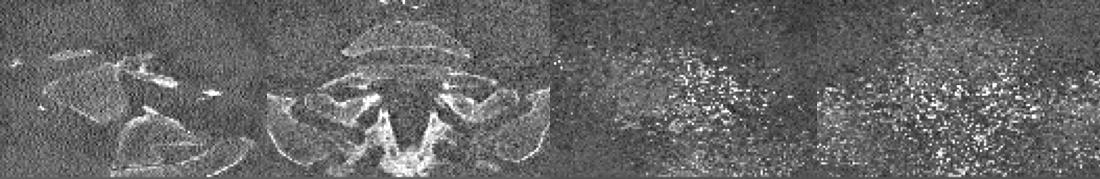

index 86 is out of bounds for axis 0 with size 86
index 86 is out of bounds for axis 0 with size 86
[*] Snapshot saved: /data1/practical-sose23/castellvi/3D-Castellvi-Prediction/tmp/sub-116_type-snp.jpg


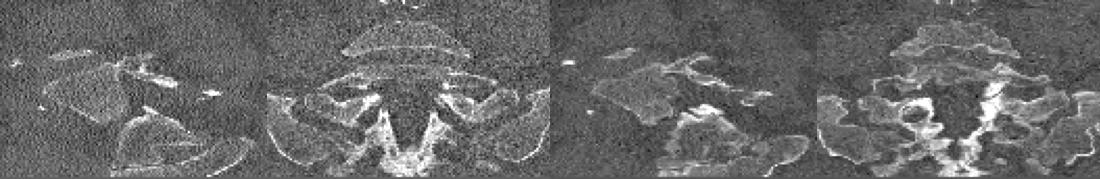

index 86 is out of bounds for axis 0 with size 86
index 86 is out of bounds for axis 0 with size 86
[*] Snapshot saved: /data1/practical-sose23/castellvi/3D-Castellvi-Prediction/tmp/sub-116_type-snp.jpg


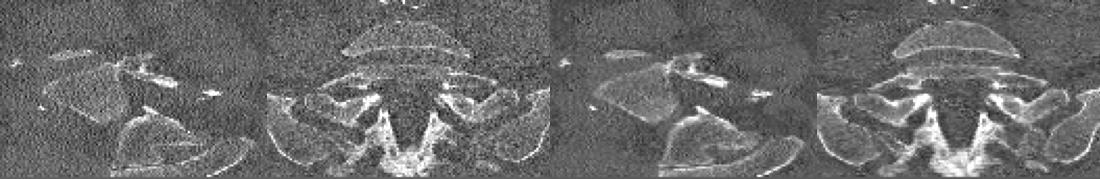

In [72]:
sigma_ranges = [(1, 1), (3, 3), (7, 7)]

for sigma_range in sigma_ranges:
    aug_params = Namespace(
        sigma_range=sigma_range,
        magnitude_range=(100, 100),
        rotate_range=None,
        shear_range=None,
        translate_range=None,
        scale_range=None
    )

    visualize_augmentations(aug_params, save_niis=False, num_subjects=1)


The higher the sigma parameter is the more are global structures preserved. Low values are unacceptable in our case since they might change the true castellvi label. The reason is that the sigma parameter is the standard deviation of the Gaussian filter applied to the image. The lower the standard deviation, the "pointier" the filter, broader filters smooth out the image more.
For a sigma value of 3 the transformed images look unacceptably more "wobbly" to the point that we may destroy the labels. 7 seems to be reasonable, so we may start with a range of (5,9) to get some variety.

Now let's turn to the magnitude parameter.

index 86 is out of bounds for axis 0 with size 86
index 86 is out of bounds for axis 0 with size 86
[*] Snapshot saved: /data1/practical-sose23/castellvi/3D-Castellvi-Prediction/tmp/sub-116_type-snp.jpg


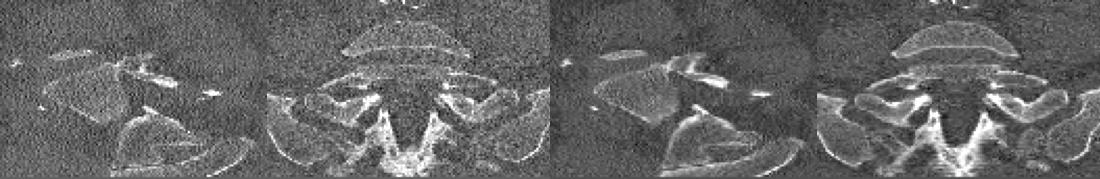

index 86 is out of bounds for axis 0 with size 86
index 86 is out of bounds for axis 0 with size 86
[*] Snapshot saved: /data1/practical-sose23/castellvi/3D-Castellvi-Prediction/tmp/sub-116_type-snp.jpg


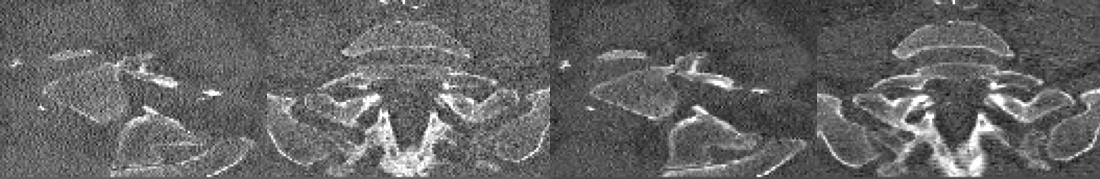

index 86 is out of bounds for axis 0 with size 86
index 86 is out of bounds for axis 0 with size 86
[*] Snapshot saved: /data1/practical-sose23/castellvi/3D-Castellvi-Prediction/tmp/sub-116_type-snp.jpg


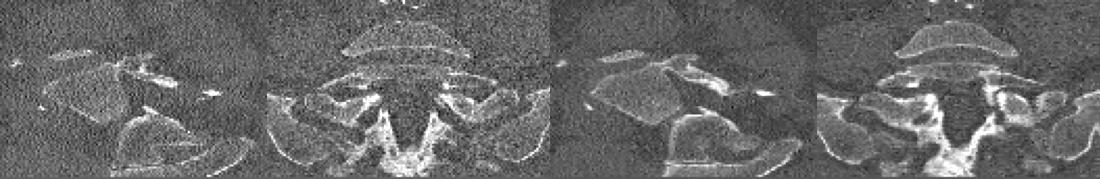

index 86 is out of bounds for axis 0 with size 86
index 86 is out of bounds for axis 0 with size 86
[*] Snapshot saved: /data1/practical-sose23/castellvi/3D-Castellvi-Prediction/tmp/sub-116_type-snp.jpg


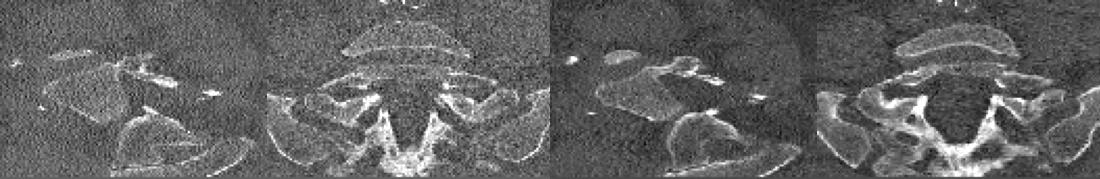

index 86 is out of bounds for axis 0 with size 86
index 86 is out of bounds for axis 0 with size 86
[*] Snapshot saved: /data1/practical-sose23/castellvi/3D-Castellvi-Prediction/tmp/sub-116_type-snp.jpg


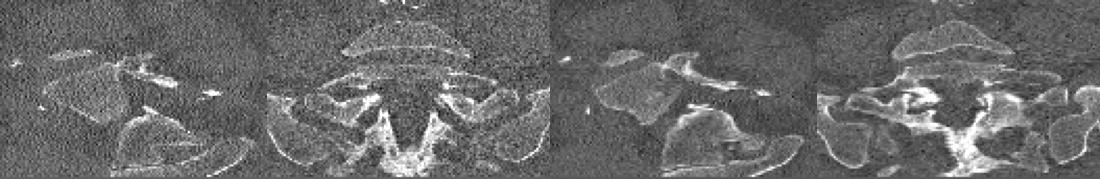

In [74]:
magnitude_ranges = [(100, 100), (200, 200), (300, 300), (400, 400), (500, 500)]

for magnitude_range in magnitude_ranges:
    aug_params = Namespace(
        sigma_range=(7, 7),
        magnitude_range=magnitude_range,
        rotate_range=None,
        shear_range=None,
        translate_range=None,
        scale_range=None
    )

    visualize_augmentations(aug_params, save_niis=False, num_subjects=1)

(100, 300) seems to produce reasonable results, above that again some local structures change significantly.
Shear, translation, rotation and scaling are a lot more intuitive to guess reasonable values.

Let's visualize the zero out.

In [95]:
def zero_out(img, seg):
    l_idx = 25 if 25 in seg else 24 if 24 in seg else 23
    l_mask = seg == l_idx #create a mask for values belonging to lowest L
    sac_mask = seg == 26 #Sacrum is always denoted by value of 26
    lsac_mask = (l_mask + sac_mask) != 0
    return img * lsac_mask
    

def visualize_zero_out(save_niis=False, num_subjects = 10):
    subs = [116,131,145,260,411,414,510,512,550,616,712,713][:num_subjects]

    #define affine matrix to change (PIL) coordinates to (RAS) coordinates
    affine = np.array([[ 0,  0,  1,  0],
       [-1,  0,  0,  0],
       [ 0, -1,  0,  0],
       [ 0,  0,  0,  1]])

    #load images and apply transformations to each of them
    imgs = [np.load("/data1/practical-sose23/castellvi/3D-Castellvi-Prediction/data/cutouts/shape_128_86_136/sub-verse{}_castellvi-cutout_ct_iso.npy".format(sub)) for sub in subs],
    segs = [np.load("/data1/practical-sose23/castellvi/3D-Castellvi-Prediction/data/cutouts/shape_128_86_136/sub-verse{}_castellvi-cutout_seg_iso.npy".format(sub)) for sub in subs]
    transformed_imgs = [zero_out(imgs[i], segs[i]) for i in range(len(imgs))]

    img_nibs = [nib.Nifti1Image(dataobj=np.array(img.squeeze()), affine=affine) for img in imgs]
    transformed_nibs = [nib.Nifti1Image(dataobj=np.array(img.squeeze()), affine=affine) for img in transformed_imgs]

    img_niis = [BIDS.NII(nibabel_nifty) for nibabel_nifty in img_nibs]
    transformed_niis = [BIDS.NII(nibabel_nifty) for nibabel_nifty in transformed_nibs]

    for idx, sub in enumerate(subs):
        if save_niis:
            img_niis[idx].save("/data1/practical-sose23/castellvi/3D-Castellvi-Prediction/tmp/sub-{}_type-ct.nii.gz".format(sub), verbose=False)
            transformed_niis[idx].save("/data1/practical-sose23/castellvi/3D-Castellvi-Prediction/tmp/sub-{}_type-transformed.nii.gz".format(sub), verbose=False)
        frames = [Snapshot_Frame(img_niis[idx],mode="MRI",sagittal=True,coronal=True), Snapshot_Frame(transformed_niis[idx],sagittal=True,coronal=True)]
        create_snapshot("/data1/practical-sose23/castellvi/3D-Castellvi-Prediction/tmp/sub-{}_type-snp.jpg".format(sub),frames)

    for sub in subs:
        display(Image(filename="/data1/practical-sose23/castellvi/3D-Castellvi-Prediction/tmp/sub-{}_type-snp.jpg".format(sub)))

5196
index 86 is out of bounds for axis 0 with size 86
index 86 is out of bounds for axis 0 with size 86
[*] Snapshot saved: /data1/practical-sose23/castellvi/3D-Castellvi-Prediction/tmp/sub-116_type-snp.jpg


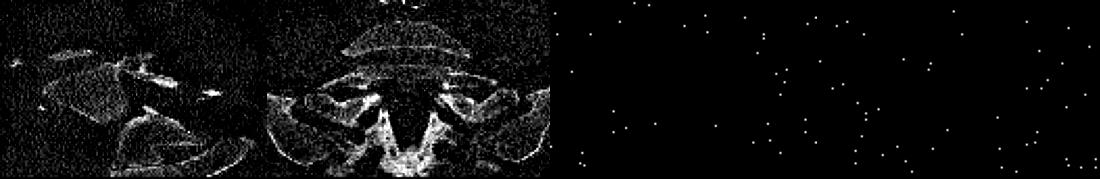

In [96]:
visualize_zero_out(save_niis=False, num_subjects=1)